In [1]:
library(randomForest)
library(readr)
library(dplyr)
library(rpart)
library(caret)
library(nnet)
library(vip)

set.seed(42)

data <- read_csv("nsw.csv", show_col_types = FALSE)
categorical_columns <- c(
  "Gender", "Industry", "FamilyStatus",
  "Location",  "ManagingRole", "MentalHealth"
)
numeric_columns <- c(
  "Age", "Experience", "Commuting", "WorkEfficiency", "Housework", "FamilyTime",
  "RemoteWorkExtent", "RemoteWorkSupport", "Productivity",
  "InterpersonalRelationships", "SocialIsolation", "Sleep",
  "EconomicResources", "RemoteWorkCompatability", "Motivation",
  "PhysicalEnvironment", "Wellbeing", "PhysicalHealth",
  "Sociability"
)

data[categorical_columns] <- lapply(data[categorical_columns], as.factor)
data[numeric_columns] <- lapply(data[numeric_columns], as.numeric)
data[numeric_columns] <- lapply(data[numeric_columns], scale)

head(data)
dim(data)

Warning message:
"package 'randomForest' was built under R version 4.3.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'caret' was built under R version 4.3.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.3.3"

Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice

Warning message:
"package 'vip' was built under R version 4.3.3"

Attaching package: 'vip'


The following object is masked from 'package:utils':

    vi




Age,Gender,Experience,Industry,FamilyStatus,Location,InterpersonalRelationships,Commuting,WorkEfficiency,Housework,⋯,Motivation,PhysicalEnvironment,Wellbeing,MentalHealth,PhysicalHealth,Sociability,ManagingRole,RemoteWorkExtent,RemoteWorkSupport,Productivity
"<dbl[,1]>",<fct>,"<dbl[,1]>",<fct>,<fct>,<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>,"<dbl[,1]>","<dbl[,1]>",<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0.25489190,Male,0.9403261,Other Services,Couple with dependent children,Metro,-1.1175702,-0.61964823,1.3719844,-0.2207096,⋯,-0.166609,0.01176681,1.2139968,3,0.7859694,-0.5502987,No,0.004252265,1.0535760,1.0775389
0.67971175,Male,0.9403261,Construction,Couple with no dependent children,Metro,0.1261208,-0.26621209,1.3719844,1.5534631,⋯,-0.166609,0.01176681,-0.1433854,2,-0.5255189,-0.5502987,No,-1.203391119,-0.5638055,1.0775389
0.08496397,Female,-2.0368490,Financial and Insurance,Single person,Metro,-1.1175702,-0.61964823,-0.2026512,0.6663767,⋯,1.258600,1.40417235,-0.1433854,3,-0.5255189,-1.9432116,No,1.211895650,1.0535760,-0.4822014
1.44438746,Female,-0.5482615,Health Care and Social Assistance,One parent family with dependent children,Regional,-1.1175702,0.79409634,-0.2026512,-1.9948822,⋯,-1.591818,-1.38063873,-1.5007676,3,0.7859694,0.8426142,Yes,0.004252265,-0.5638055,1.0775389
-0.50978381,Male,-0.5482615,Manufacturing,Couple with dependent children,Metro,0.1261208,0.08722406,-0.2026512,1.5534631,⋯,-0.166609,0.01176681,-0.1433854,2,-0.5255189,-0.5502987,No,0.004252265,-0.5638055,-0.4822014
0.50978381,Male,0.9403261,Public Administration and Safety,Couple with dependent children,Metro,-1.1175702,0.08722406,-0.2026512,-0.2207096,⋯,1.258600,0.01176681,-0.1433854,3,0.7859694,0.8426142,Yes,1.211895650,-0.5638055,-0.4822014


[1] 1420   25

In [2]:
min_class_size <- data %>%
  count(MentalHealth) %>%
  summarise(min_size = min(n)) %>%
  pull(min_size)

# Undersample all classes to the smallest class size
data <- data %>%
  group_by(MentalHealth) %>%
  slice_sample(n = min_class_size) %>%
  ungroup()

table(data$MentalHealth)


  1   2   3 
155 155 155 

In [3]:
train_index <- createDataPartition(data$MentalHealth, p = 0.8, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

table(train_data$MentalHealth)
table(test_data$MentalHealth)


  1   2   3 
124 124 124 


 1  2  3 
31 31 31 

In [4]:
model <- multinom(MentalHealth ~ ., data = train_data)
predicted_classes <- predict(model, test_data, type = "class")

conf_matrix <- confusionMatrix(
  factor(predicted_classes, levels = levels(test_data$MentalHealth)),
  test_data$MentalHealth
)
conf_matrix

# weights:  144 (94 variable)
initial  value 408.683771 
iter  10 value 286.574853
iter  20 value 262.762700
iter  30 value 257.981611
iter  40 value 256.137398
iter  50 value 255.058335
iter  60 value 254.459774
iter  70 value 254.332171
iter  80 value 254.129722
iter  90 value 252.656116
iter 100 value 252.653805
final  value 252.653805 
stopped after 100 iterations


Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 20  9  3
         2  9 13 12
         3  2  9 16

Overall Statistics
                                          
               Accuracy : 0.5269          
                 95% CI : (0.4206, 0.6314)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 9.324e-05       
                                          
                  Kappa : 0.2903          
                                          
 Mcnemar's Test P-Value : 0.8899          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6452   0.4194   0.5161
Specificity            0.8065   0.6613   0.8226
Pos Pred Value         0.6250   0.3824   0.5926
Neg Pred Value         0.8197   0.6949   0.7727
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.2151   0.1398   0.1720
Detection Prevalence   0.3441   0.3656   0.2903
Balanced Accuracy      0.7258   0.5403   0.6694

In [5]:
coeffs <- summary(model)$coefficients

# Average absolute value of coefficients for each feature across classes
feature_influence <- apply(abs(coeffs), 2, mean)

# Rank the features by their average magnitude to find the most influential ones
feature_influence_df <- data.frame(
  Feature = names(feature_influence),
  Importance = feature_influence
)

# Sort features by their importance
feature_influence_df <- feature_influence_df[
  order(-feature_influence_df$Importance),
]
feature_influence_df

Warning message in sqrt(diag(vc)):
"NaNs produced"


,Feature,Importance
,<chr>,<dbl>
IndustryMining,IndustryMining,358.9691305
"IndustryRental, Hiring and Real Estate","IndustryRental, Hiring and Real Estate",261.8592042
"IndustryElectricity, Gas, Water and Waste","IndustryElectricity, Gas, Water and Waste",243.8007126
IndustryWholesale Trade,IndustryWholesale Trade,105.1734496
IndustryConstruction,IndustryConstruction,105.0715194
"IndustryAgriculture, Forestry and Fishing","IndustryAgriculture, Forestry and Fishing",104.6238553
IndustryEducation and Training,IndustryEducation and Training,104.5452116
IndustryManufacturing,IndustryManufacturing,104.1903668
IndustryInformation Media and Telecommunications,IndustryInformation Media and Telecommunications,103.9774393


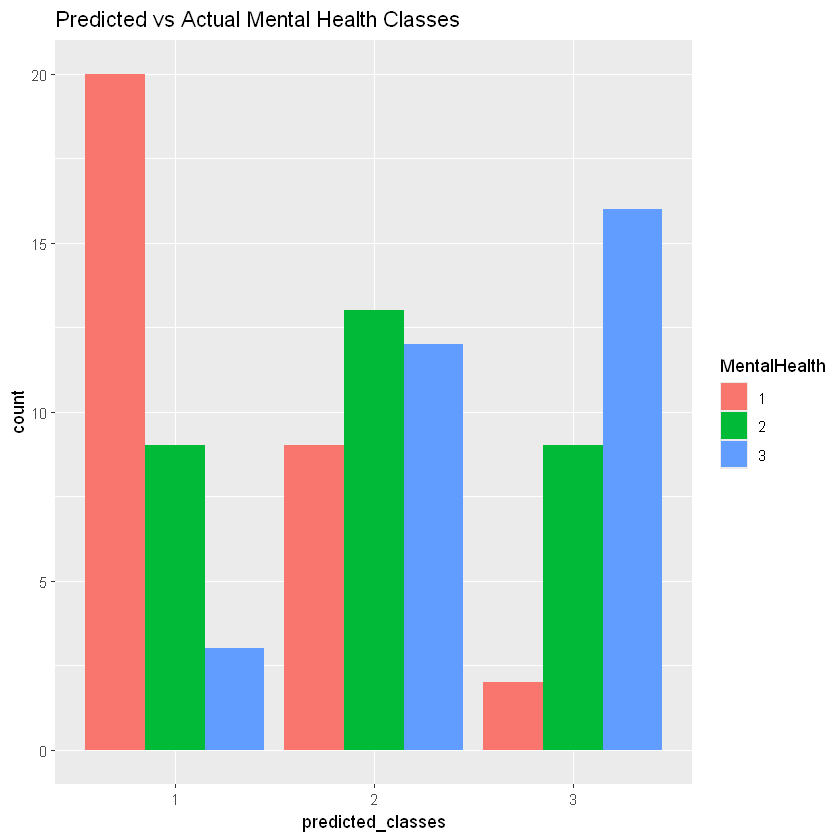

In [6]:
ggplot(data = test_data, aes(x = predicted_classes, fill = MentalHealth)) +
  geom_bar(position = "dodge") +
  labs(title = "Predicted vs Actual Mental Health Classes")

In [7]:
rf_model <- randomForest(MentalHealth ~ ., data = train_data)
rf_predictions <- predict(rf_model, test_data)
rf_conf_matrix <- confusionMatrix(rf_predictions, test_data$MentalHealth)
rf_conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction  1  2  3
         1 21  6  4
         2  7 19  8
         3  3  6 19

Overall Statistics
                                          
               Accuracy : 0.6344          
                 95% CI : (0.5281, 0.7319)
    No Information Rate : 0.3333          
    P-Value [Acc > NIR] : 2.855e-09       
                                          
                  Kappa : 0.4516          
                                          
 Mcnemar's Test P-Value : 0.9177          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity            0.6774   0.6129   0.6129
Specificity            0.8387   0.7581   0.8548
Pos Pred Value         0.6774   0.5588   0.6786
Neg Pred Value         0.8387   0.7966   0.8154
Prevalence             0.3333   0.3333   0.3333
Detection Rate         0.2258   0.2043   0.2043
Detection Prevalence   0.3333   0.3656   0.3011
Balanced Accuracy      0.7581   0.6855   0.7339

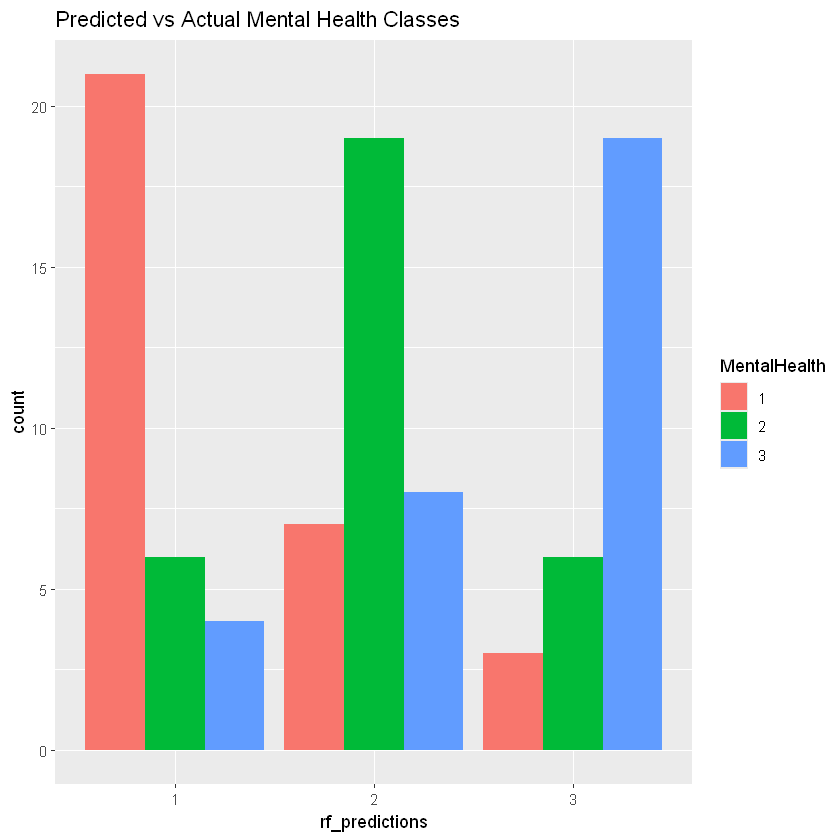

In [8]:
ggplot(data = test_data, aes(x = rf_predictions, fill = MentalHealth)) +
  geom_bar(position = "dodge") +
  labs(title = "Predicted vs Actual Mental Health Classes")